<a href="https://colab.research.google.com/github/dafeRoy/pytorch_projects/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: d_roy71@yahoo.co.uk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:06<00:00, 115MB/s]


In [ ]:
import torch # Main PyTorch Library
import torch.nn as nn # Used for creating the layers and loss function
from torchvision import datasets, transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

In [ ]:
"""The following code will be going through a nested directory structure where images are stored
within subdirectories, each directory is representing a specific label (category). It constructs
a list of the file paths for these images and their corresponding labels. Then, it creates a pandas
DataFrame containing this information, which is useful for further data processing."""

'The following code will be going through a nested directory structure where images are stored\nwithin subdirectories, each directory is representing a specific label (category). It constructs\na list of the file paths for these images and their corresponding labels. Then, it creates a pandas\nDataFrame containing this information, which is useful for further data processing.'

In [ ]:
image_path = [] # Empty array where we will fill the paths of the images
labels = [] # Empty array where we will fill the labes of the images

for i in os.listdir("/content/animal-faces/afhq/"): # Looping through the first directory which has the train and val images
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"): # Looping through the first directory which has the labels folders
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"): # Looping through all the images of this label
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}") # Append/Put this image path in the list to read it later

df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels
df

,image_paths,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
...,...,...
16125,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
16126,/content/animal-faces/afhq/train/cat/flickr_ca...,cat
16127,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
16128,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [ ]:
# data split
# since we will be reading the image paths from df, it is better we split the df directly and then read the images

train = df.sample(frac=0.7, random_state=42) # 70% of the data for training
test = df.drop(train.index) # Create test data by removing the train data

val = test.sample(frac=0.5, random_state=42) # create validation data of 50% from test data
test = test.drop(val.index) # data remaining for test

In [ ]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(df['labels']) # Fit the label encoder on our own data

# we can also use .map
# df["labels"] = df["labels"].map({"cat":0, "dog":1, "wild":2})

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

In [ ]:
train

,image_paths,labels
7900,/content/animal-faces/afhq/train/dog/flickr_do...,dog
2254,/content/animal-faces/afhq/train/wild/flickr_w...,wild
13538,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
7171,/content/animal-faces/afhq/train/dog/flickr_do...,dog
6051,/content/animal-faces/afhq/train/wild/flickr_w...,wild
...,...,...
205,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
9327,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
6680,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2749,/content/animal-faces/afhq/train/wild/pixabay_...,wild


In [ ]:
# custom dataset class

# We will not read each image inside the constructor as reading images here will be so time consuming.
# However, we are reading each image, applying the preprocessing and returning it in the __getitem__ .

class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(df['labels'])) # Encode the labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index, 0]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# create dataset objects for training, testing, and validation
train_dataset = CustomImageDataset(train, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)

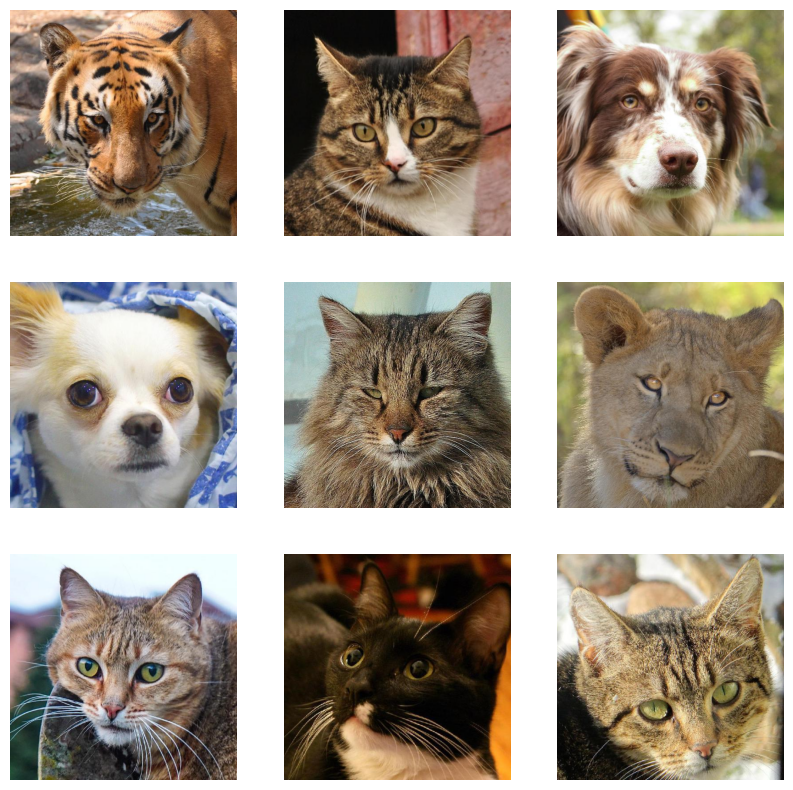

In [ ]:
# visualizing images just to see what they look like
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(1)['image_paths'].iloc[0]).convert('RGB')
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
plt.show()

In [ ]:
# hyperparameters
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
# dataloaders

# When we train, we loop through epochs, in batches for efficiency instead of looping through all the training data at once.
# Dataloader allows you to loop through the batches easily during the training. You define the batch size and enable
# shuffle to randomize the data and then you can loop through it in each epoch to train normally.

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# model

# The model will start by having a 2-d convolution neural network that will have input channels of 3
# which is the RGB input channels. Outputting 32 feature map. Then another 2-d convolution neural network
# taking 32 channels and outputting 64 and finally another one taking 64 channels and outputting 128 feature map.
# Each 2-d convolution neural network will be followed by a max pooling layer of size 2x2 and a ReLU activation function.

# After that we will have a flatten layer to vectorize these feature maps followed by a linear layer which will have
# shape of (128, 16, 16) which means 128 feature map each one is 16x16 as the image started by 128x128 and got divided
# by 2 three times after each pooling layers. finally we will have an output linear layer with the length of the unique values of the labels.

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # first convolution later
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # second
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # third
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # pooling layer
        self.relu = nn.ReLU() # activation function

        self.flatten = nn.Flatten() # flatten layer
        self.fc = nn.Linear(128 * 16 * 16, 3) # linear layer (fully connected)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      x = self.conv1(x) # outputs: (32, 128, 128)
      x = self.relu(x)
      x = self.pool(x) # outputs: (32, 64, 64)
      x = self.conv2(x) # outputs: (64, 64, 64)
      x = self.relu(x)
      x = self.pool(x) # outputs: (64, 32, 32)
      x = self.conv3(x) # outputs: (128, 32, 32)
      x = self.relu(x)
      x = self.pool(x) # outputs: (128, 16, 16)
      x = self.flatten(x) # outputs: (128 * 16 * 16)
      x = self.fc(x) # outputs: (3)
      x = self.softmax(x)

      return x

"""
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x
"""

model = ConvolutionalNetwork()
#model = Net()

In [ ]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# training
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    ## Training and Validation
    for inputs, labels in train_loader:
        prediction = model(inputs)
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()

        acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for inputs, labels in val_loader:
            prediction = model(inputs)
            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()

            acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1}/{EPOCHS} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train_dataset.__len__())*100):.4f}
              Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(val_dataset.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1/10 Train Loss: 0.5882 Train Accuracy: 71.7917
              Validation Loss: 0.1071 Validation Accuracy: 85.2066
Epoch no. 2/10 Train Loss: 0.4829 Train Accuracy: 87.0959
              Validation Loss: 0.1050 Validation Accuracy: 86.2810
Epoch no. 3/10 Train Loss: 0.4651 Train Accuracy: 89.6201
              Validation Loss: 0.1044 Validation Accuracy: 86.1983
Epoch no. 4/10 Train Loss: 0.4523 Train Accuracy: 91.4179
              Validation Loss: 0.0997 Validation Accuracy: 89.4215
Epoch no. 5/10 Train Loss: 0.4424 Train Accuracy: 92.8616
              Validation Loss: 0.0952 Validation Accuracy: 92.7686
Epoch no. 6/10 Train Loss: 0.4356 Train Accuracy: 93.7118
              Validation Loss: 0.0960 Validation Accuracy: 91.9421
Epoch no. 7/10 Train Loss: 0.4302 Train Accuracy: 94.5355
              Validation Loss: 0.0931 Validation Accuracy: 94.1736
Epoch no. 8/10 Train Loss: 0.4236 Train Accuracy: 95.4477
              Validation Loss: 0.0924 Validation Accuracy: 94.5041


In [ ]:
# evaluate model on test data set
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 94.8326 and Loss is 0.0915


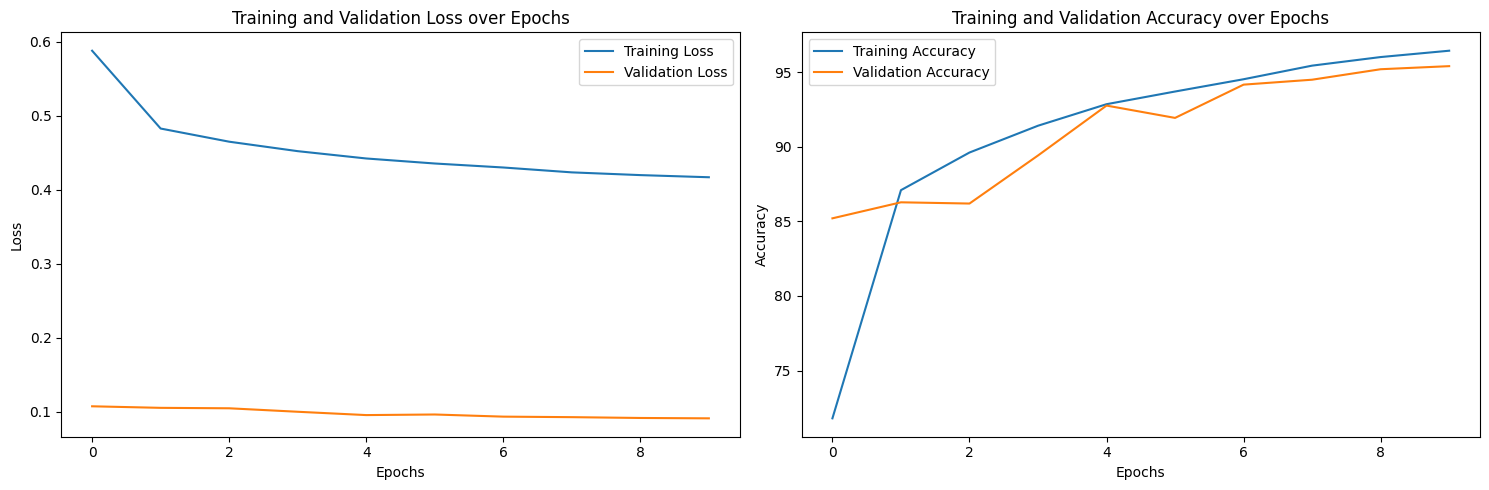

In [ ]:
# plotting and visualization
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

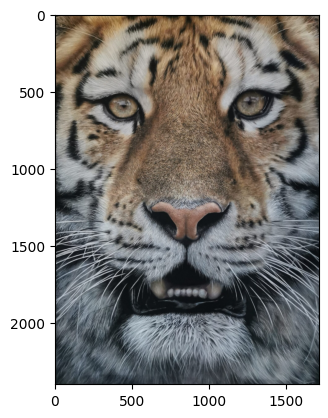


Prediction: 



array(['wild'], dtype=object)

In [ ]:
# Now lets see how we can use the model in inference mode, inference means making predictions like you are in production.
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/davidshepherd-pic.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/davidshepherd-pic.jpg")